### In this Notebook finetune YOLO v8 model using a custom dataset previously generated

The folder Structure is as follow:

this_notebook.ipynb

Dataset_yolo

  ->Images

    ->Train_images
    ->Val_images
  ->Labels

    -> Train_labels
    -> VAL_labels



In [ ]:
# ONLY RUN GOOGLE COLAB, Mount Google Drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
cd /content/drive/MyDrive/'Colab Notebooks/human-activity-understanding/HW2'

/content/drive/MyDrive/Colab Notebooks/human-activity-understanding/HW2


In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random

def parse_yolo_label(label_path, img_width, img_height):
    """
    Parses a YOLO format segmentation label file and returns a list of masks.
    Each mask is returned as (class_id, polygon_points) where polygon_points is a list of (x, y) tuples in pixel coordinates.
    """
    masks = []
    if not os.path.exists(label_path):
        print(f"Warning: Label file not found: {label_path}")
        return masks

    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 3: # Must have at least class_id, x1, y1
                class_id = int(parts[0])
                polygon_normalized = list(map(float, parts[1:]))

                # Convert normalized coordinates to pixel coordinates
                polygon_points = []
                for i in range(0, len(polygon_normalized), 2):
                    x = int(polygon_normalized[i] * img_width)
                    y = int(polygon_normalized[i+1] * img_height)
                    polygon_points.append((x, y))
                masks.append((class_id, polygon_points))
    return masks

def draw_bboxes_and_labels(image, masks, classes):
    """
    Draws segmentation masks and class labels on an image with semi-transparent colors.
    """
    img_copy = image.copy()
    overlay = img_copy.copy()
    alpha = 0.4  # Transparency factor

    # Define a set of distinct colors for classes (BGR format for OpenCV)
    class_colors = [
        (0, 0, 155),    # Red for class 0 (person)
        (0, 155, 0),    # Green for class 1 (table)
        (155, 0, 0),    # Blue for class 2 (leg)
        (0, 155, 155),  # Yellow for class 3 (tool1)
        (155, 0, 155)   # Magenta for class 4 (tool2)
    ]

    for class_id, polygon_points in masks:
        if polygon_points:
            # Get color for the class
            color = class_colors[class_id % len(class_colors)] if class_id < len(class_colors) else (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)) # Fallback random color

            # Reshape points for cv2.fillPoly and cv2.polylines
            pts = np.array(polygon_points, np.int32)
            pts = pts.reshape((-1, 1, 2))

            # Fill the polygon on the overlay with semi-transparency
            cv2.fillPoly(overlay, [pts], color)

            # Draw polygon outline
            cv2.polylines(img_copy, [pts], True, color, 2)

            # Put label
            label = classes[class_id] if class_id < len(classes) else f"Unknown Class {class_id}"
            font = cv2.FONT_HERSHEY_SIMPLEX
            font_scale = 0.7
            font_thickness = 2
            text_size = cv2.getTextSize(label, font, font_scale, font_thickness)[0]

            # Place text near the first point of the polygon
            text_x = polygon_points[0][0]
            text_y = polygon_points[0][1] - 10 if polygon_points[0][1] - 10 > text_size[1] else polygon_points[0][1] + text_size[1] + 10

            # Draw background for text
            cv2.rectangle(img_copy, (text_x, text_y - text_size[1] - 5),
                          (text_x + text_size[0] + 5, text_y + 5), color, -1)
            cv2.putText(img_copy, label, (text_x, text_y), font, font_scale, (255, 255, 255), font_thickness, cv2.LINE_AA)

    # Combine the original image with the overlay using the transparency factor
    img_with_masks = cv2.addWeighted(overlay, alpha, img_copy, 1 - alpha, 0)
    return img_with_masks

print("Modified helper functions `parse_yolo_label` and `draw_bboxes_and_labels` to handle segmentation masks with semi-transparent class-specific colors.")

Modified helper functions `parse_yolo_label` and `draw_bboxes_and_labels` to handle segmentation masks with semi-transparent class-specific colors.


Visualizing 3 random images...


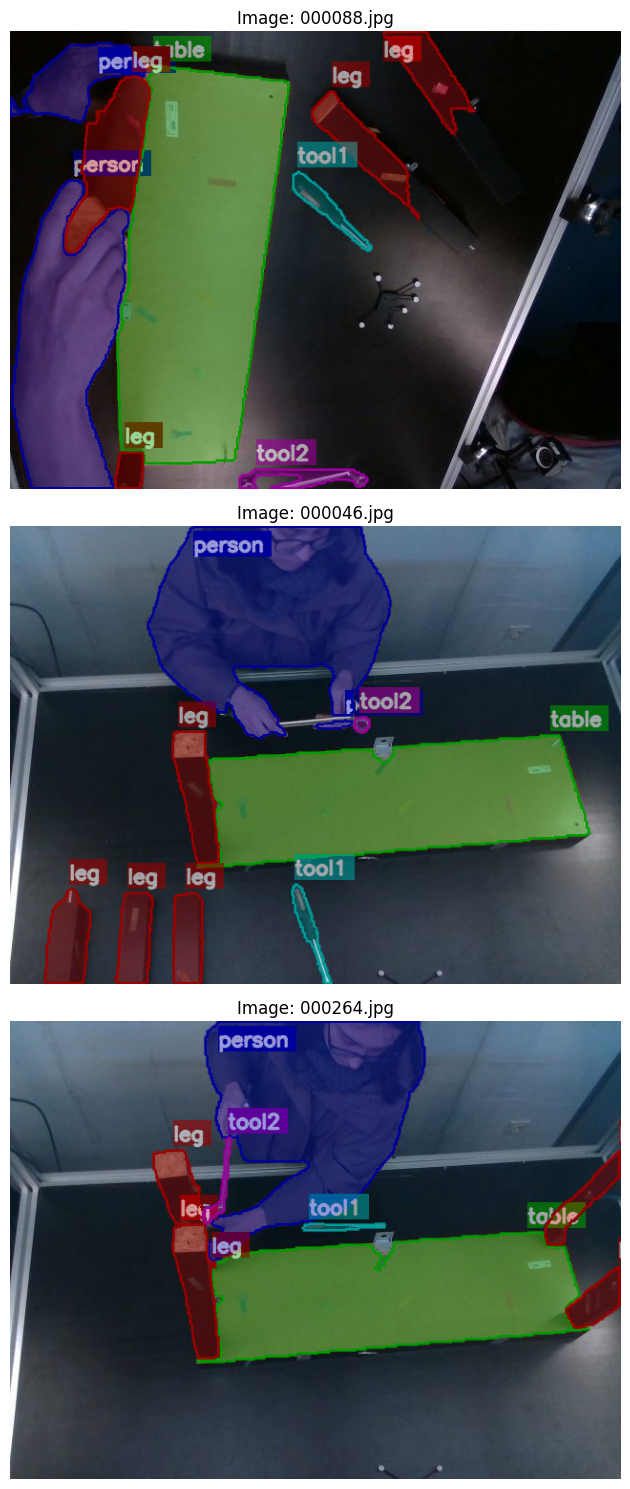

Finished visualizing 3 images with bounding boxes.


In [ ]:
import os
import random
import cv2
import matplotlib.pyplot as plt

# Define the new directories
TRAIN_IMAGES_DIR = 'train_images'
TRAIN_LABELS_DIR = os.path.join(TRAIN_IMAGES_DIR, 'labels')
CLASSES = ['person','table', 'leg','tool1', 'tool2']
# Get a list of all image files in the new training directory
train_image_files = [f for f in os.listdir(TRAIN_IMAGES_DIR) if f.lower().endswith(('.jpg', '.jpeg'))]

# Randomly select 3 images to visualize
num_images_to_visualize = min(3, len(train_image_files)) # Ensure we don't try to visualize more than available
selected_images_for_viz = random.sample(train_image_files, num_images_to_visualize)

print(f"Visualizing {num_images_to_visualize} random images...")

plt.figure(figsize=(15, 5 * num_images_to_visualize))

for i, img_filename in enumerate(selected_images_for_viz):
    img_path = os.path.join(TRAIN_IMAGES_DIR, img_filename)
    label_filename = os.path.splitext(img_filename)[0] + '.txt'
    label_path = os.path.join(TRAIN_LABELS_DIR, label_filename)

    # Read the image
    img = cv2.imread(img_path)
    if img is None:
        print(f"Warning: Could not read image: {img_path}")
        continue

    # OpenCV reads images as BGR, convert to RGB for matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img_height, img_width, _ = img_rgb.shape

    # Parse YOLO labels
    bboxes = parse_yolo_label(label_path, img_width, img_height)

    # Draw bounding boxes and labels
    img_with_boxes = draw_bboxes_and_labels(img_rgb, bboxes, CLASSES)

    # Display the image
    plt.subplot(num_images_to_visualize, 1, i + 1)
    plt.imshow(img_with_boxes)
    plt.title(f"Image: {img_filename}")
    plt.axis('off')

plt.tight_layout()
plt.show()

print(f"Finished visualizing {num_images_to_visualize} images with bounding boxes.")

**Reasoning**:
The subtask requires installing the `ultralytics` package using pip. I will use a code block to execute the pip install command.



In [ ]:
get_ipython().system('pip install ultralytics')
print("ultralytics package installed.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.4 MB/s eta 0:00:00
ultralytics package installed.


## Prepare Dataset for Ultralytics

Organize custom dataset into the YOLO format required by `ultralytics`, including creating a `data.yaml` configuration file that specifies paths to your training/validation images and labels, and defines class names.


In [ ]:
import os
import shutil
import random

# 2. Define variables for the original training images directory, labels directory, and class names
TRAIN_IMAGES_DIR = 'train_images'
TRAIN_LABELS_DIR = os.path.join(TRAIN_IMAGES_DIR, 'labels')
CLASSES = ['person', 'table', 'leg', 'tool1', 'tool2']

# 3. Define a new base directory for the YOLO dataset
dataset_yolo_path = 'dataset_yolo'

# 4. Create the necessary subdirectories for the YOLO format
os.makedirs(os.path.join(dataset_yolo_path, 'images', 'train'), exist_ok=True)
os.makedirs(os.path.join(dataset_yolo_path, 'images', 'val'), exist_ok=True)
os.makedirs(os.path.join(dataset_yolo_path, 'labels', 'train'), exist_ok=True)
os.makedirs(os.path.join(dataset_yolo_path, 'labels', 'val'), exist_ok=True)
print("YOLO dataset directories created.")

# 5. Get a list of all image files in the training directory
image_files = [f for f in os.listdir(TRAIN_IMAGES_DIR) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

# 6. Create a list of tuples (image_path, label_path) and filter out images without corresponding labels
data_pairs = []
for img_filename in image_files:
    img_path = os.path.join(TRAIN_IMAGES_DIR, img_filename)
    label_filename = os.path.splitext(img_filename)[0] + '.txt'
    label_path = os.path.join(TRAIN_LABELS_DIR, label_filename)
    if os.path.exists(label_path):
        data_pairs.append((img_path, label_path))
    else:
        print(f"Warning: No label file found for {img_filename}. Skipping.")

print(f"Found {len(data_pairs)} image-label pairs.")

# 7. Split into training and validation sets (80% train, 20% val)
random.shuffle(data_pairs)
train_split_idx = int(0.8 * len(data_pairs))
train_set = data_pairs[:train_split_idx]
val_set = data_pairs[train_split_idx:]

print(f"Training set size: {len(train_set)} images")
print(f"Validation set size: {len(val_set)} images")

# 8. Iterate through the training set and copy files
for img_path, label_path in train_set:
    img_filename = os.path.basename(img_path)
    label_filename = os.path.basename(label_path)
    shutil.copy(img_path, os.path.join(dataset_yolo_path, 'images', 'train', img_filename))
    shutil.copy(label_path, os.path.join(dataset_yolo_path, 'labels', 'train', label_filename))
print("Training images and labels copied.")

# 9. Iterate through the validation set and copy files
for img_path, label_path in val_set:
    img_filename = os.path.basename(img_path)
    label_filename = os.path.basename(label_path)
    shutil.copy(img_path, os.path.join(dataset_yolo_path, 'images', 'val', img_filename))
    shutil.copy(label_path, os.path.join(dataset_yolo_path, 'labels', 'val', label_filename))
print("Validation images and labels copied.")

# 10. and 11. Create a data.yaml file
data_yaml_content = f"""
path: {dataset_yolo_path}
train: images/train
val: images/val

nc: {len(CLASSES)}
names: {CLASSES}
"""

with open('data.yaml', 'w') as f:
    f.write(data_yaml_content)

print("data.yaml created.")
print("Dataset organized and data.yaml generated successfully.")

YOLO dataset directories created.
Found 91 image-label pairs.
Training set size: 72 images
Validation set size: 19 images
Training images and labels copied.
Validation images and labels copied.
data.yaml created.
Dataset organized and data.yaml generated successfully.


## Load Pre-trained Ultralytics Model

Load a suitable pre-trained YOLOv8 from the `ultralytics` hub as a starting point for fine-tuning.


In [ ]:
from ultralytics import YOLO

# Load a pre-trained YOLOv8 segmentation model
model = YOLO('yolov8n-seg.pt')

print("Pre-trained YOLOv8 segmentation model 'yolov8n-seg.pt' loaded successfully.")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Pre-trained YOLOv8 segmentation model 'yolov8n-seg.pt' loaded successfully.


## Configure Model for Fine-tuning

Define the training parameters, including the number of epochs, batch size, and most importantly, adjust the model to match the number of classes in your custom dataset.


In [ ]:
model.train(data='data.yaml', epochs=50, imgsz=640, name='yolov8n_seg_custom')
print("Model training initiated with custom dataset and specified parameters.")

Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8n_seg_custom, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.

## Test Fine-tuned Model


Test the fine-tuned YOLOv8 segmentation model on validation images and visualize the results, including bounding boxes and semi-transparent segmentation masks.


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Loaded fine-tuned model from: runs/segment/yolov8n_seg_custom/weights/best.pt
Visualizing 3 random validation images...


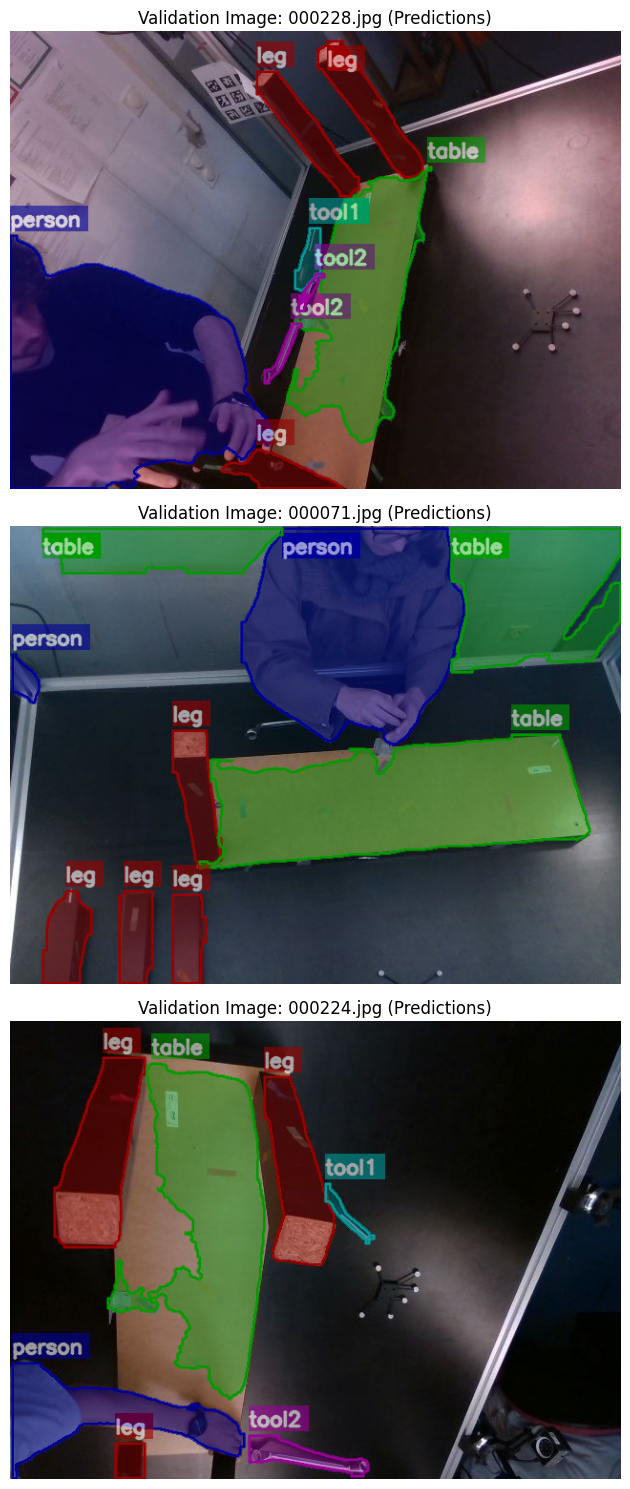

Finished visualizing predictions for 3 validation images.


In [ ]:
import os
import random
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Load the best trained model weights
model_path = os.path.join('runs', 'segment', 'yolov8n_seg_custom', 'weights', 'best.pt')
model = YOLO(model_path)

print(f"Loaded fine-tuned model from: {model_path}")

# Define the new directories and classes (same as used for training)
TRAIN_IMAGES_DIR = 'train_images'
TRAIN_LABELS_DIR = os.path.join(TRAIN_IMAGES_DIR, 'labels')
CLASSES = ['person', 'table', 'leg', 'tool1', 'tool2']

# Path to the YOLO dataset validation images
val_images_dir = os.path.join('dataset_yolo', 'images', 'val')
val_labels_dir = os.path.join('dataset_yolo', 'labels', 'val')

# Get a list of all image files in the validation directory
val_image_files = [f for f in os.listdir(val_images_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

# Randomly select 3 images to visualize from the validation set
num_images_to_visualize = min(3, len(val_image_files)) # Ensure we don't try to visualize more than available
selected_images_for_viz = random.sample(val_image_files, num_images_to_visualize)

print(f"Visualizing {num_images_to_visualize} random validation images...")

plt.figure(figsize=(15, 5 * num_images_to_visualize))

for i, img_filename in enumerate(selected_images_for_viz):
    img_path = os.path.join(val_images_dir, img_filename)

    # Read the image
    img = cv2.imread(img_path)
    if img is None:
        print(f"Warning: Could not read image: {img_path}")
        continue

    # OpenCV reads images as BGR, convert to RGB for matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Run inference
    results = model(img_rgb, verbose=False) # verbose=False to suppress output for each image

    # Process results to get masks in the desired format
    predicted_masks = []
    for r in results:
        if r.masks is not None:
            for j, mask_data in enumerate(r.masks.data):
                class_id = int(r.boxes.cls[j])
                # Convert mask to polygon points
                # Ultralytics masks are typically (H, W) boolean arrays or similar
                # Let's extract contours from the mask to get polygon points
                # Need to convert mask_data (tensor) to numpy array if it's not already
                mask_np = mask_data.cpu().numpy().astype(np.uint8)
                contours, _ = cv2.findContours(mask_np, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                if contours:
                    # Take the largest contour for simplicity if multiple are found
                    contour = max(contours, key=cv2.contourArea)
                    # Reshape to (N, 2) list of tuples for draw_bboxes_and_labels
                    polygon_points = [tuple(point[0]) for point in contour]
                    predicted_masks.append((class_id, polygon_points))

    # Draw bounding boxes and labels using the existing helper function
    # The helper function expects pixel coordinates for polygon_points, which we extracted.
    img_with_predictions = draw_bboxes_and_labels(img_rgb, predicted_masks, CLASSES)

    # Display the image
    plt.subplot(num_images_to_visualize, 1, i + 1)
    plt.imshow(img_with_predictions)
    plt.title(f"Validation Image: {img_filename} (Predictions)")
    plt.axis('off')

plt.tight_layout()
plt.show()

print(f"Finished visualizing predictions for {num_images_to_visualize} validation images.")


In [ ]:
import cv2
import numpy as np
import random

def draw_rect_boxes_and_labels(image, boxes, classes):
    """
    Draws rectangular bounding boxes and class labels on an image.
    """
    img_copy = image.copy()

    # Define a set of distinct colors for classes (BGR format for OpenCV)
    class_colors = [
        (0, 0, 155),    # Red for class 0 (person)
        (0, 155, 0),    # Green for class 1 (table)
        (155, 0, 0),    # Blue for class 2 (leg)
        (0, 155, 155),  # Yellow for class 3 (tool1)
        (155, 0, 155)   # Magenta for class 4 (tool2)
    ]

    if boxes is not None and len(boxes) > 0:
        for box_data in boxes:
            x1, y1, x2, y2 = map(int, box_data.xyxy[0])
            class_id = int(box_data.cls[0])

            # Get color for the class
            color = class_colors[class_id % len(class_colors)] if class_id < len(class_colors) else (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)) # Fallback random color

            # Draw rectangle
            cv2.rectangle(img_copy, (x1, y1), (x2, y2), color, 2)

            # Put label
            label = classes[class_id] if class_id < len(classes) else f"Unknown Class {class_id}"
            font = cv2.FONT_HERSHEY_SIMPLEX
            font_scale = 0.7
            font_thickness = 2
            text_size = cv2.getTextSize(label, font, font_scale, font_thickness)[0]

            # Place text above the bounding box
            text_x = x1
            text_y = y1 - 10 if y1 - 10 > text_size[1] else y1 + text_size[1] + 10

            # Draw background for text
            cv2.rectangle(img_copy, (text_x, text_y - text_size[1] - 5),
                          (text_x + text_size[0] + 5, text_y + 5), color, -1)
            cv2.putText(img_copy, label, (text_x, text_y), font, font_scale, (255, 255, 255), font_thickness, cv2.LINE_AA)

    return img_copy

print("New helper function `draw_rect_boxes_and_labels` defined to draw only rectangular bounding boxes and labels.")

New helper function `draw_rect_boxes_and_labels` defined to draw only rectangular bounding boxes and labels.


In [ ]:
import os
import random
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Load the best trained model weights
model_path = os.path.join('runs', 'segment', 'yolov8n_seg_custom', 'weights', 'best.pt')
model = YOLO(model_path)

print(f"Loaded fine-tuned model from: {model_path}")

# Define the new directories and classes (same as used for training)
TRAIN_IMAGES_DIR = 'train_images'
TRAIN_LABELS_DIR = os.path.join(TRAIN_IMAGES_DIR, 'labels')
CLASSES = ['person', 'table', 'leg', 'tool1', 'tool2']

# Path to the YOLO dataset validation images
val_images_dir = os.path.join('dataset_yolo', 'images', 'val')
val_labels_dir = os.path.join('dataset_yolo', 'labels', 'val')

# Get a list of all image files in the validation directory
val_image_files = [f for f in os.listdir(val_images_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

Loaded fine-tuned model from: runs/segment/yolov8n_seg_custom/weights/best.pt


Visualizing 3 random validation images (only bounding boxes)...


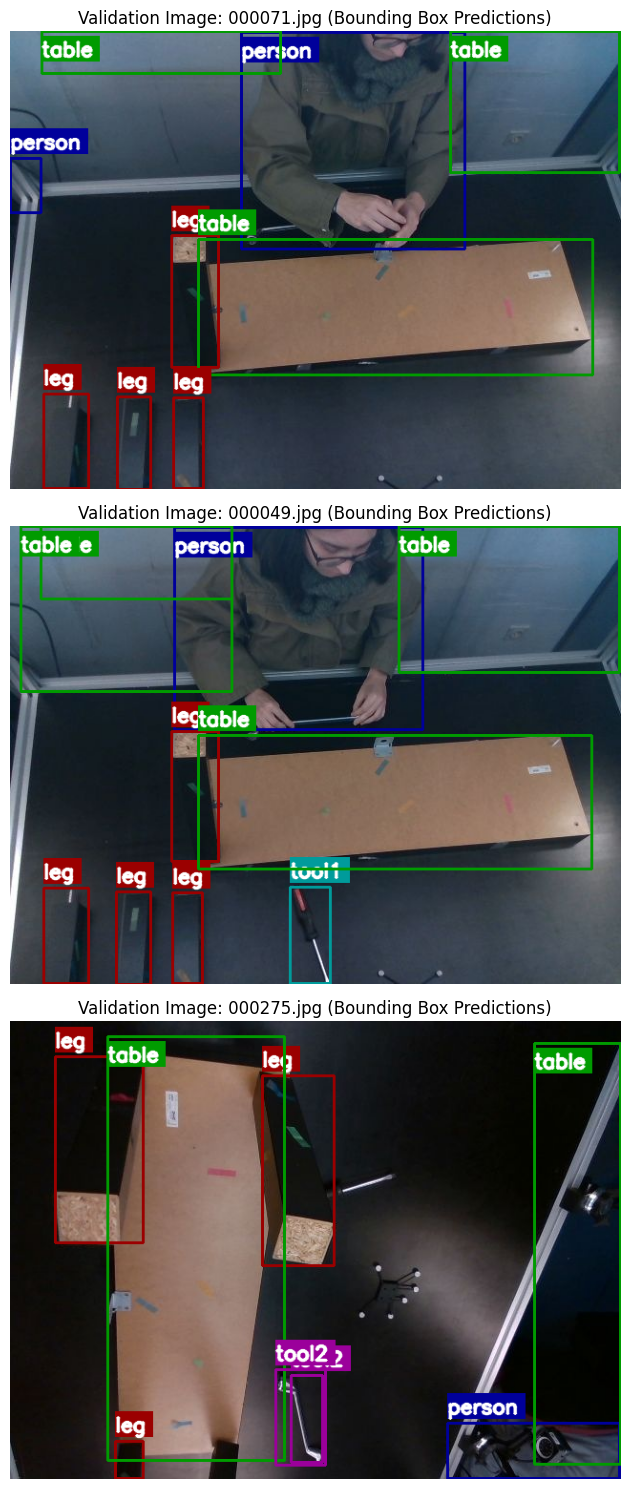

Finished visualizing bounding box predictions for 3 validation images.


In [ ]:


# Randomly select 3 images to visualize from the validation set
num_images_to_visualize = min(3, len(val_image_files)) # Ensure we don't try to visualize more than available
selected_images_for_viz = random.sample(val_image_files, num_images_to_visualize)

print(f"Visualizing {num_images_to_visualize} random validation images (only bounding boxes)...")

plt.figure(figsize=(15, 5 * num_images_to_visualize))

for i, img_filename in enumerate(selected_images_for_viz):
    img_path = os.path.join(val_images_dir, img_filename)

    # Read the image
    img = cv2.imread(img_path)
    if img is None:
        print(f"Warning: Could not read image: {img_path}")
        continue

    # OpenCV reads images as BGR, convert to RGB for matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Run inference
    results = model(img_rgb, verbose=False) # verbose=False to suppress output for each image

    # Draw only bounding boxes and labels using the new helper function
    # We pass r.boxes directly, which contains xyxy coordinates
    for r in results:
        img_with_predictions = draw_rect_boxes_and_labels(img_rgb, r.boxes, CLASSES)

    # Display the image
    plt.subplot(num_images_to_visualize, 1, i + 1)
    plt.imshow(img_with_predictions)
    plt.title(f"Validation Image: {img_filename} (Bounding Box Predictions)")
    plt.axis('off')

plt.tight_layout()
plt.show()

print(f"Finished visualizing bounding box predictions for {num_images_to_visualize} validation images.")

In [ ]:
import os
import random
import cv2
import numpy as np
from ultralytics import YOLO

# 1. Load the best trained YOLOv8 segmentation model weights
model_path = os.path.join('runs', 'segment', 'yolov8n_seg_custom', 'weights', 'best.pt')
model = YOLO(model_path)

print(f"Loaded fine-tuned model from: {model_path}")

# 2. Define the path to the validation images directory
val_images_dir = os.path.join('dataset_yolo', 'images', 'val')

# 3. Get a list of all image filenames in the validation directory
val_image_files = [f for f in os.listdir(val_images_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

if not val_image_files:
    print("Error: No validation images found.")
else:
    # 4. Randomly select one image filename
    selected_img_filename = random.choice(val_image_files)
    selected_img_path = os.path.join(val_images_dir, selected_img_filename)

    # 6. Read the selected image and convert to RGB
    original_img_bgr = cv2.imread(selected_img_path)
    if original_img_bgr is None:
        print(f"Warning: Could not read image: {selected_img_path}. Skipping.")
    else:
        original_img_rgb = cv2.cvtColor(original_img_bgr, cv2.COLOR_BGR2RGB)

        # 7. Run inference on the RGB image
        results = model(original_img_rgb, verbose=False)

        # 8. Check if any objects were detected and select the first one
        selected_bbox = None
        selected_mask_data = None
        selected_class_id = None

        for r in results:
            if r.boxes and len(r.boxes) > 0 and r.masks is not None and len(r.masks) > 0:
                # Get the first detected object's bounding box and mask
                selected_bbox = r.boxes[0] # xyxy format is in selected_bbox.xyxy[0]
                selected_mask_data = r.masks.data[0] # mask tensor
                selected_class_id = int(r.boxes.cls[0])
                break # Only take the first detected object

        if selected_bbox is not None and selected_mask_data is not None:
            print(f"Selected image: {selected_img_filename}")
            print(f"Selected object: Class ID {selected_class_id}, BBox: {selected_bbox.xyxy[0].cpu().numpy()}")

            # Convert mask data (tensor) to numpy array if it's not already
            # The mask needs to be resized to the original image dimensions if it's not already.
            # Ultralytics masks are typically (H, W) or (N, H, W) where H, W might be model output size.
            # It's usually automatically resized by r.masks.xy or r.masks.segments if used for visualization.
            # For K-Means on the actual pixel data, we need the mask at original image resolution.

            # r.masks.data is the raw mask tensor, often at reduced resolution.
            # r.masks.xy can give points scaled to original image. r.masks.xyn gives normalized points.
            # For K-Means on the image region, we need a binary mask at image resolution.

            # Let's get the full resolution mask from results
            mask_at_img_res = selected_mask_data.cpu().numpy() # This is typically a bool/float mask at input size or slightly smaller

            # If mask_at_img_res is not the same size as original_img_rgb, resize it
            if mask_at_img_res.shape[0] != original_img_rgb.shape[0] or mask_at_img_res.shape[1] != original_img_rgb.shape[1]:
                mask_at_img_res = cv2.resize(mask_at_img_res.astype(np.uint8),
                                             (original_img_rgb.shape[1], original_img_rgb.shape[0]),
                                             interpolation=cv2.INTER_NEAREST)

            # Ensure it's a boolean mask
            mask_at_img_res = mask_at_img_res.astype(bool)

            # Store relevant data for K-Means
            # global_original_img_rgb = original_img_rgb # Make it accessible globally if needed
            # global_selected_bbox = selected_bbox
            # global_mask_at_img_res = mask_at_img_res

            print("First detected object (bounding box and mask) selected for K-Means segmentation.")
        else:
            print(f"No objects detected in {selected_img_filename} or masks were not available.")

Loaded fine-tuned model from: runs/segment/yolov8n_seg_custom/weights/best.pt
Selected image: 000139.jpg
Selected object: Class ID 2, BBox: [     322.11      8.5254      433.65      155.43]
First detected object (bounding box and mask) selected for K-Means segmentation.


## Extract Object Bounding Box



Cropped image shape: (147, 111, 3)


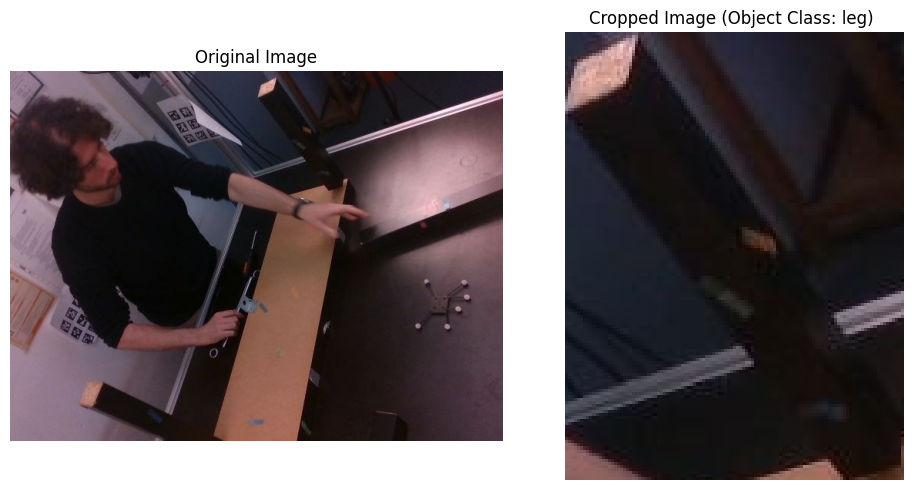

In [ ]:
import matplotlib.pyplot as plt

# 1. Extract bounding box coordinates and convert to integers
x1, y1, x2, y2 = map(int, selected_bbox.xyxy[0].cpu().numpy())

# Ensure coordinates are within image bounds
img_height, img_width, _ = original_img_rgb.shape
x1 = max(0, x1)
y1 = max(0, y1)
x2 = min(img_width, x2)
y2 = min(img_height, y2)

# 2. Crop the original_img_rgb using these integer coordinates
cropped_image_rgb = original_img_rgb[y1:y2, x1:x2]

# 3. Print the shape of the cropped_image_rgb to verify
print(f"Cropped image shape: {cropped_image_rgb.shape}")

# Display the original and cropped images for verification
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(original_img_rgb)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cropped_image_rgb)
plt.title(f"Cropped Image (Object Class: {CLASSES[selected_class_id]}) ")
plt.axis('off')

plt.tight_layout()
plt.show()

Assigned K-Means cluster 0 as foreground and 1 as background based on YOLO mask correlation.


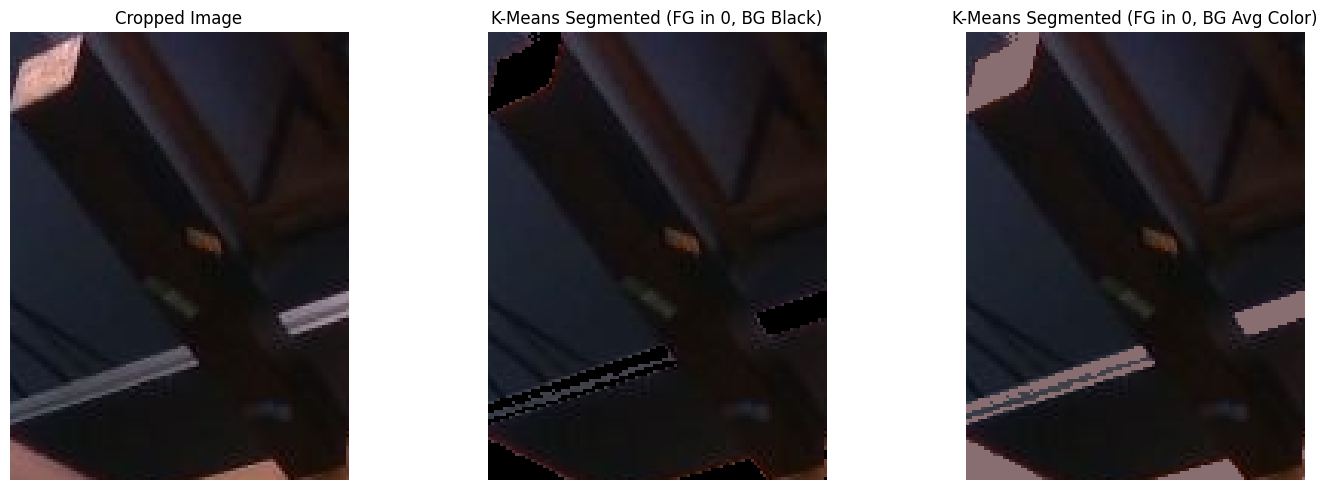

K-Means clustering applied to the cropped image, and results visualized.


In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 1. Reshape the image data for K-Means
# Convert to a 2D array (pixels, channels)
h, w, c = cropped_image_rgb.shape
reshaped_image = cropped_image_rgb.reshape((h * w, c))

# 2. Apply K-Means clustering with 2 clusters (foreground and background)
k = 2 # Number of clusters
kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
kmeans.fit(reshaped_image)

# Get cluster labels for each pixel
labels = kmeans.labels_

# Get the cluster centers (average color of each cluster)
centers = kmeans.cluster_centers_ # (k, c)

# 3. Determine which cluster is foreground and which is background
# A simple heuristic: choose the cluster with the brightest average color as foreground (or vice versa)
# This might need adjustment based on the image content.
# For now, let's assume cluster 0 is background and cluster 1 is foreground, or assign based on the mask.

# Let's try to assign foreground based on the original YOLO mask within the cropped region
# First, crop the original YOLO mask to the bounding box region
cropped_mask = mask_at_img_res[y1:y2, x1:x2]

# Find the average label value within the 'true' foreground region of the cropped mask
# If most pixels in the YOLO foreground are assigned to label 0 by K-Means, then 0 is foreground.
# If most pixels in the YOLO foreground are assigned to label 1 by K-Means, then 1 is foreground.

# Flatten the cropped_mask and corresponding labels for easier comparison
flat_cropped_mask = cropped_mask.flatten()
flat_labels = labels

# Count how many foreground pixels (from YOLO) belong to each K-Means cluster
# Only consider pixels that are within the YOLO mask AND within the cropped image boundaries

# Filter labels corresponding to the YOLO foreground within the cropped region
foreground_pixels_labels = flat_labels[flat_cropped_mask]

if len(foreground_pixels_labels) > 0:
    # Count occurrences of each label in the foreground pixels
    label_counts = np.bincount(foreground_pixels_labels, minlength=k)
    if np.sum(label_counts) > 0: # Ensure there are foreground pixels
        foreground_cluster_label = np.argmax(label_counts) # The cluster label most frequent in YOLO's foreground
    else:
        # Fallback if no foreground pixels in mask (shouldn't happen with valid YOLO detection)
        foreground_cluster_label = 0 # Default to 0, or some other heuristic
else:
    foreground_cluster_label = 0 # Fallback

background_cluster_label = 1 - foreground_cluster_label # The other cluster is background

print(f"Assigned K-Means cluster {foreground_cluster_label} as foreground and {background_cluster_label} as background based on YOLO mask correlation.")

# 4. Reconstruct the segmented image
# Create an output image where foreground is kept, background is black
segmented_image = np.zeros_like(cropped_image_rgb)

# Apply the segmentation. Pixels belonging to the foreground cluster get their original color.
segmented_image[labels.reshape(h, w) == foreground_cluster_label] = cropped_image_rgb[labels.reshape(h, w) == foreground_cluster_label]

# Create another version where foreground is kept and background is masked to average background color
background_color = centers[background_cluster_label].astype(np.uint8)
segmented_image_avg_bg = np.zeros_like(cropped_image_rgb)
segmented_image_avg_bg[labels.reshape(h, w) == foreground_cluster_label] = cropped_image_rgb[labels.reshape(h, w) == foreground_cluster_label]
segmented_image_avg_bg[labels.reshape(h, w) == background_cluster_label] = background_color

# 5. Visualize results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(cropped_image_rgb)
plt.title("Cropped Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(segmented_image)
plt.title(f"K-Means Segmented (FG in {foreground_cluster_label}, BG Black)")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(segmented_image_avg_bg)
plt.title(f"K-Means Segmented (FG in {foreground_cluster_label}, BG Avg Color)")
plt.axis('off')

plt.tight_layout()
plt.show()

print("K-Means clustering applied to the cropped image, and results visualized.")

## Create K-Means Segmentation Mask

Based on the K-Means cluster labels, assign each pixel in the cropped region to either foreground or background. Reconstruct a binary mask for the foreground within the bounding box, and then extend this mask to the original image dimensions.


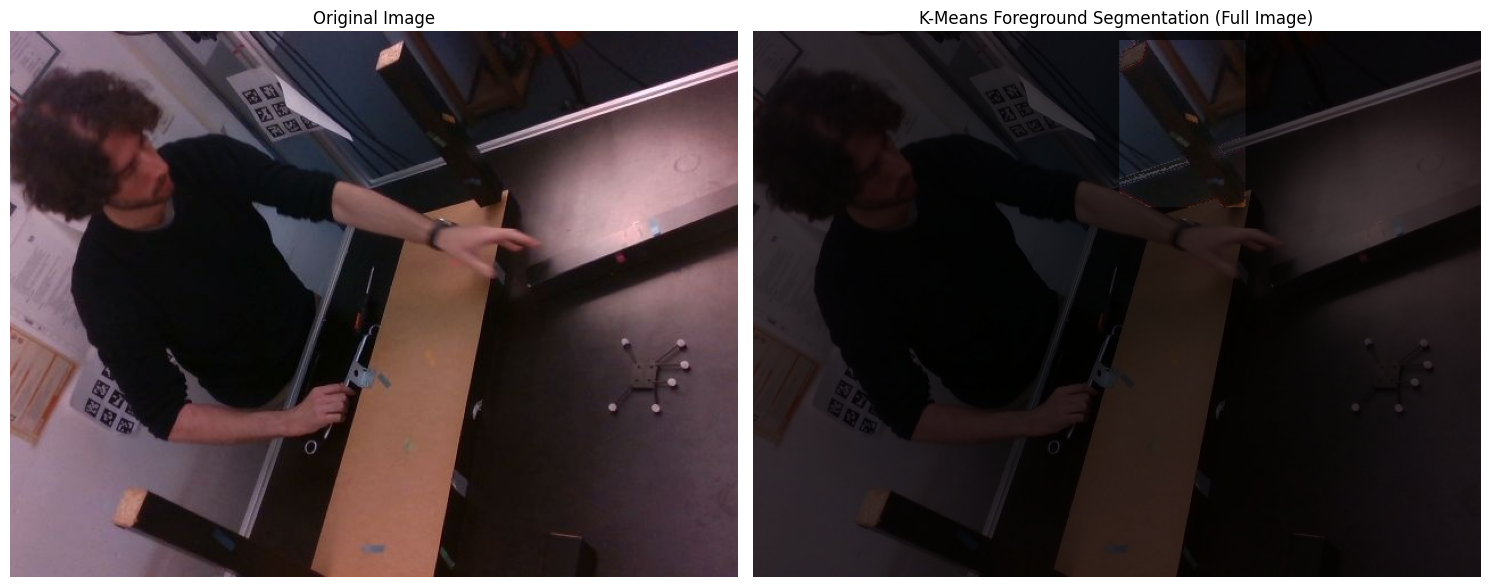

K-Means foreground mask generated and visualized on the full image.


In [ ]:
import matplotlib.pyplot as plt

# 1. Reshape the K-Means labels back into a 2D array matching the dimensions of cropped_image_rgb
# (h, w, c) was the shape of cropped_image_rgb
kmeans_labels_2d = labels.reshape(h, w)

# 2. Create a binary mask for the foreground within the cropped region
kmeans_foreground_mask_cropped = (kmeans_labels_2d == foreground_cluster_label)

# 3. Initialize an empty 2D boolean array for the full image dimensions
img_height_full, img_width_full, _ = original_img_rgb.shape
kmeans_foreground_mask_full = np.zeros((img_height_full, img_width_full), dtype=bool)

# 4. Copy the kmeans_foreground_mask_cropped into kmeans_foreground_mask_full using bounding box coordinates
kmeans_foreground_mask_full[y1:y2, x1:x2] = kmeans_foreground_mask_cropped

# 5. Create a visual representation of the kmeans_foreground_mask_full
# Create a copy of the original image
visual_segmentation = original_img_rgb.copy()

# Set pixels outside the foreground mask to a specific color (e.g., a darker version of the original background)
# We'll make background pixels semi-transparent or darkened
background_pixels = ~kmeans_foreground_mask_full

# Create a darkened version of the original image for the background
darkened_background = (original_img_rgb * 0.3).astype(np.uint8)

# Combine foreground and darkened background
visual_segmentation[background_pixels] = darkened_background[background_pixels]


plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.imshow(original_img_rgb)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(visual_segmentation)
plt.title("K-Means Foreground Segmentation (Full Image)")
plt.axis('off')

plt.tight_layout()
plt.show()

print("K-Means foreground mask generated and visualized on the full image.")